In [ ]:
from stellargraph.data import EdgeSplitter
import stellargraph as sg
import numpy as np
from sklearn.model_selection import train_test_split
import multiprocessing
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score
import networkx as nx
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA

## Constansok

In [ ]:
# ['0', '107']
edge_path = 'facebook/0.edges' # 0.edges

In [ ]:
def create_mapping(path):
    with open(path, 'rt') as file:
        text = file.read()

    # Feldolgozom a sorokat
    connections = []
    from_list = []
    to_list = []
    for row in text.split('\n')[:-1]:
        a, b = [int(x) for x in row.split(' ')]
        connections.append((a, b))

        from_list.append(a)
        to_list.append(b)


    id_mapper = {}
    reverse_id_mapper = {}
    counter = 0
    for elem in from_list:
        if elem not in id_mapper.values():
            id_mapper[counter] = elem
            reverse_id_mapper[elem] = counter
            counter += 1

    for elem in to_list:
        if elem not in id_mapper.values():
            id_mapper[counter] = elem
            reverse_id_mapper[elem] = counter
            counter += 1

    scaled_connections = []
    for first, second in connections:
        first_scaled = reverse_id_mapper[first]
        second_scaled = reverse_id_mapper[second]

        scaled_connections.append((first_scaled, second_scaled))

    return id_mapper, reverse_id_mapper, scaled_connections

def read_graph(path, map = True):
    id_mapper = None
    reverse_id_mapper = None

    if map:
        id_mapper, reverse_id_mapper, edges = create_mapping(path)
        G = nx.Graph()
        G.add_edges_from(edges)
    else:
        G = nx.read_edgelist(path, nodetype=int, create_using=nx.Graph())

    G = sg.StellarGraph.from_networkx(G)

    return G, id_mapper, reverse_id_mapper

In [ ]:
G, id_mapper, reverse_id_mapper = read_graph(edge_path, map =True)
print(G.info())


# for edge in G.edges():
#     G[edge[0]][edge[1]]['weight'] = 1

## Start

In [ ]:
edge_splitter_test = EdgeSplitter(G)

In [ ]:
# Itt az edge_splitter tesztből vesz éleket, ezeket az examples_test,
# Majd vesz negatív éleket is, ezt szintén hozzárakja az examples_test-hez concatolva,
# a labels test az, hogy ez az él létezik-e vagy sem
# a graph test a gráf a maradék éllel
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(p=0.1, method="global")

In [ ]:
def print_graph_info(graph):
    print(graph.info())

In [ ]:
print_graph_info(graph_test)

In [ ]:
edge_splitter_train = EdgeSplitter(g=graph_test, g_master=G)
graph_train, examples, labels = edge_splitter_train.train_test_split(p=0.1, method="global")



(examples_train, examples_model_selection, labels_train, labels_model_selection,)\
                                        = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

In [ ]:
print_graph_info(graph_train)

In [ ]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

In [ ]:
used_params = {
    'p': 1.0,
    'q': 0.8,
    'dimensions': 128,
    'num_walks': 100,
    'walk_length': 30,
    'window_size': 13,
    'num_iter': 5
}

In [ ]:
# p = 1.0
# q = 1.0
# dimensions = 128
# num_walks = 60
# walk_length = 60
# window_size = 16
# num_iter = 5
workers = multiprocessing.cpu_count()

In [ ]:
def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=used_params['num_walks'], length=used_params['walk_length'], p=used_params['p'], q=used_params['q'])
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        vector_size=used_params['dimensions'],
        window=used_params['window_size'],
        min_count=0,
        sg=1,
        workers=workers,
        epochs=used_params['num_iter'],
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [ ]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 33300


In [ ]:
# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]

# 2. training classifier
def train_link_prediction_model(
        link_examples, link_labels, get_embedding, binary_operator
):
    # Ezt akár lehet módosítani is más algoritmussal
    clf = link_prediction_classifier()

    # Itt távolságot számol a start és end pont embeddingje között
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    # Majd arra fitteli a modelt
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=4000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
        clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

In [ ]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }

binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [ ]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_l2'


,ROC AUC score
name,
operator_hadamard,0.923466
operator_l1,0.974383
operator_l2,0.982290
operator_avg,0.764073


In [ ]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 33300


In [ ]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_l2': 0.9429691592196949


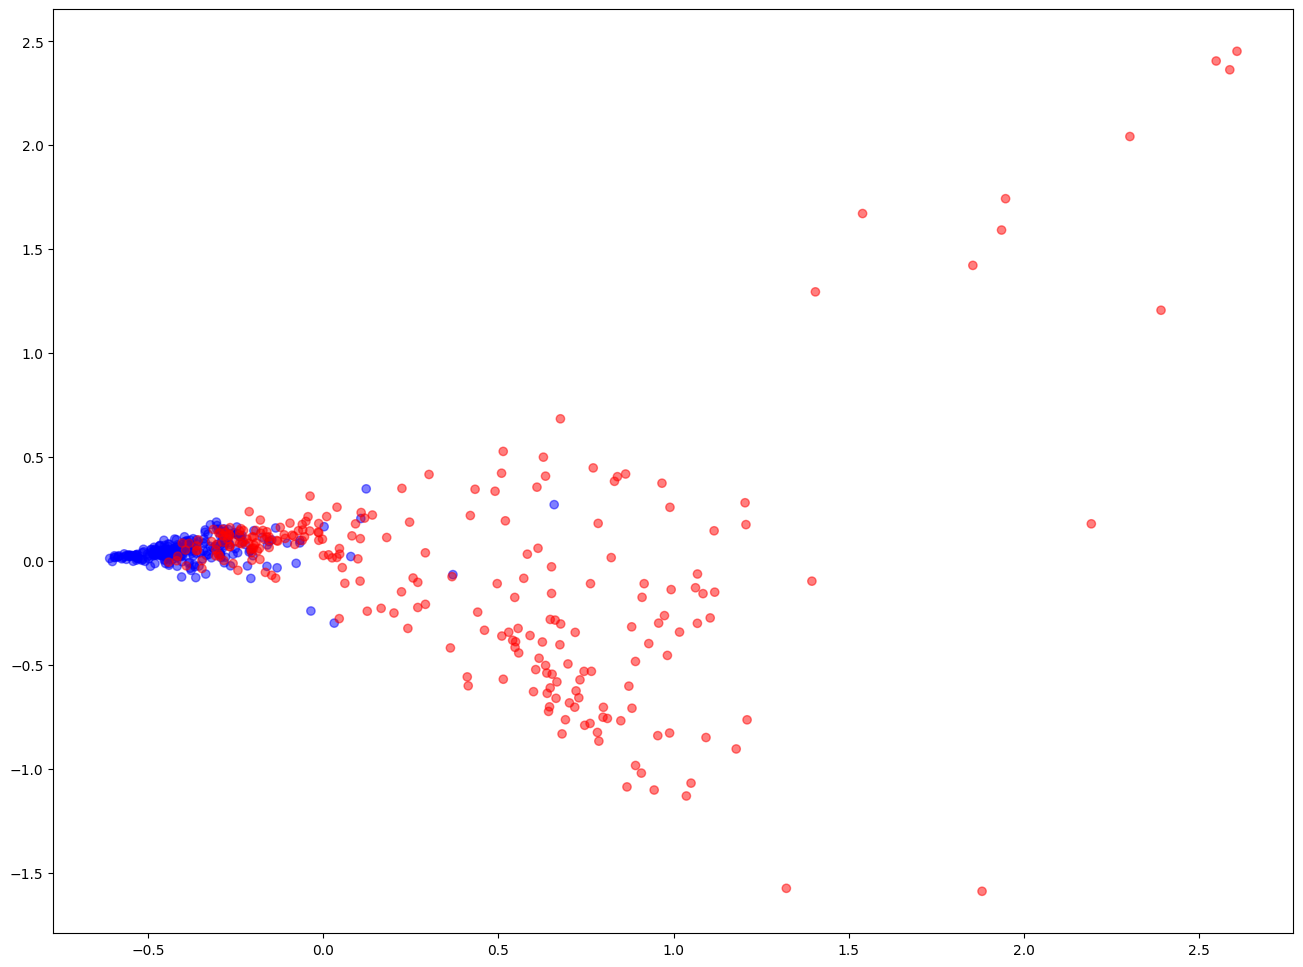

In [ ]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)

## Inference

In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 333, Edges: 2519

 Node types:
  default: [333]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [2519]
        Weights: all 1 (default)
        Features: none


In [ ]:
edge_splitter_test = EdgeSplitter(G)
graph, X, y = edge_splitter_test.train_test_split(p=0.2, method="global")

embedding_all = node2vec_embedding(graph, "Test Graph")

model = train_link_prediction_model(X, y, graph, operator_l2) # embedding_all maybe

** Sampled 503 positive and 503 negative edges. **


In [ ]:
final_model = best_result['classifier']
final_operator = best_result['binary_operator']

nodes = list(G.nodes())
nodes.sort()

In [ ]:
first_node = []
second_node = []
for node1 in nodes:
    for node2 in nodes:
        if node1 < node2:
            first_node.append(node1)
            second_node.append(node2)

In [ ]:
prob_df = pd.DataFrame({'first_node': first_node, 'second_node': second_node})

In [ ]:
processed_tmp = link_examples_to_features(prob_df.values, embedding_all, best_result['binary_operator'])

In [37]:
prob_df['prob'] = model.predict_proba(processed_tmp)[:,1]
prob_df['class'] = model.predict(processed_tmp)

In [38]:
prob_df = prob_df.set_index(['first_node', 'second_node'])

KeyError: "None of ['first_node', 'second_node'] are in the columns"

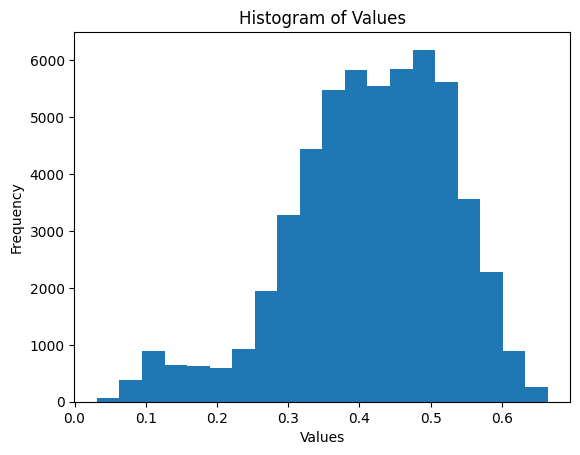

In [ ]:
# Create a histogram
plt.hist(list(prob_df['pred']), bins=20)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()

In [ ]:
graph_edges = [(min(u, v), max(u, v)) for u, v in G.edges()]
graph_df = pd.DataFrame(graph_edges, columns=['first_node', 'second_node'])

graph_df = graph_df.set_index(['first_node', 'second_node'])

graph_df['edge'] = 1

In [39]:
result_df = prob_df.join(graph_df, how = 'left')
result_df['edge'] = result_df['edge'].fillna(0)
result_df['pred_edge'] = result_df['prob'].apply(lambda x: 1 if x > 0.5 else 0)

In [40]:
result_df.head()

pred  class      prob  edge  pred_edge
first_node second_node                                            
0          1            0.583601      1  0.583601   1.0          1
           2            0.515025      1  0.515025   0.0          1
           3            0.602986      1  0.602986   1.0          1
           4            0.553776      1  0.553776   0.0          1
           5            0.548589      1  0.548589   0.0          1

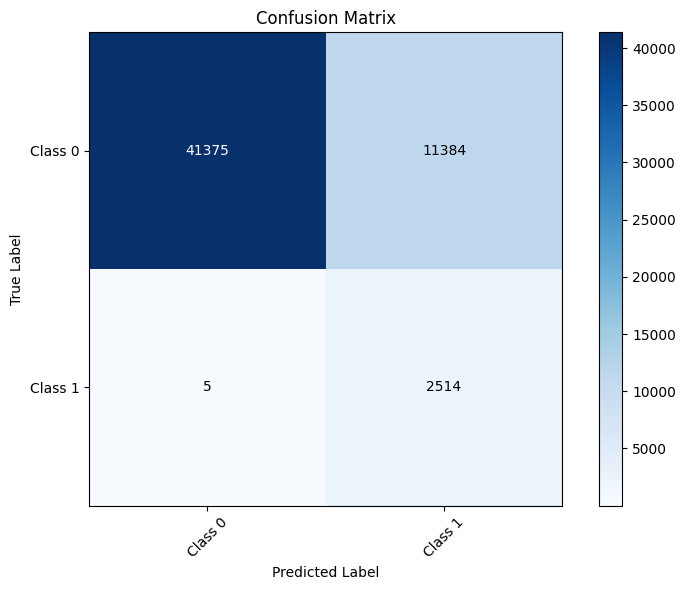

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    plt.show()


cm = confusion_matrix(result_df['edge'], result_df['pred_edge'])

# Define class labels (if applicable)
class_labels = ['Class 0', 'Class 1']

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=class_labels)

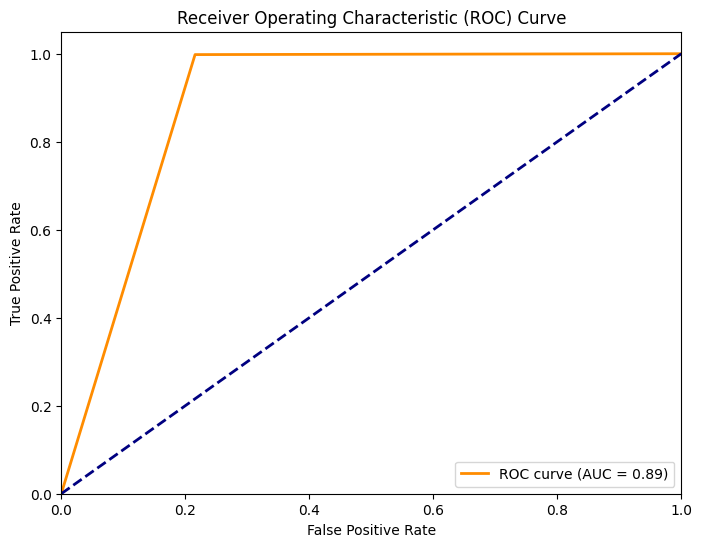

In [42]:
def plot_roc_curve(predictions_df):
    # Extract the 'Real', 'Pred', and 'Prob' columns
    ground_truth_values = predictions_df['edge'].tolist()
    predictions = predictions_df['pred_edge'].tolist()

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(ground_truth_values, predictions)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = roc_auc_score(ground_truth_values, predictions)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage:
plot_roc_curve(result_df)

In [46]:
offers = result_df[(result_df['edge'] == 0) & (result_df['pred_edge'] == 1)].reset_index()

In [64]:
result_dict = {node: None for node in G.nodes()}
recommendation_number = 5

for node in G.nodes():
    filtered_offers = offers[(offers['first_node'] == node) | (offers['second_node'] == node)].copy()

    filtered_offers['neighbor'] = filtered_offers.apply(lambda x: x['first_node'] if x['first_node'] != node else x['second_node'], axis = 1).astype('int')

    result_dict[node] = list(filtered_offers.sort_values('prob', ascending = False)['neighbor'][:recommendation_number])

In [65]:
result_dict

{0: [107, 65, 34, 89, 68],
 56: [137, 122, 86, 101, 11],
 1: [40, 137, 301, 35, 78],
 22: [40, 137, 301, 105, 89],
 2: [19, 129, 6, 139, 79],
 80: [28, 43, 39, 133, 67],
 3: [136, 58, 45, 193, 37],
 115: [91, 40, 101, 71, 47],
 4: [103, 301, 65, 40, 86],
 107: [65, 14, 89, 0, 77],
 5: [183, 214, 50, 119, 36],
 131: [34, 7, 36, 65, 29],
 6: [2, 208, 183, 28, 63],
 47: [115, 40, 3, 65, 91],
 7: [69, 11, 71, 77, 103],
 84: [101, 89, 15, 35, 107],
 8: [86, 126, 171, 84, 101],
 223: [89, 86, 3, 65, 90],
 9: [10, 60, 91, 101, 115],
 36: [86, 122, 95, 11, 77],
 10: [9, 34, 137, 171, 301],
 95: [36, 137, 29, 40, 78],
 11: [7, 36, 60, 29, 171],
 31: [91, 74, 301, 101, 68],
 12: [65, 29, 36, 1, 34],
 13: [65, 29, 34, 40, 60],
 45: [107, 3, 23, 136, 115],
 14: [107, 86, 301, 57, 101],
 78: [60, 29, 107, 109, 91],
 15: [65, 89, 40, 140, 171],
 32: [208, 88, 124, 79, 197],
 16: [160, 3, 301, 101, 4],
 18: [89, 137, 154, 301, 78],
 17: [231, 322, 281, 309, 221],
 188: [231, 241, 217, 229, 298],
 34: